In [1]:
import numpy as np
import os
import h5py
from getdist import plots, MCSamples
import getdist
import dynesty 
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import pickle

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import utils
import emulator

In [2]:
pickle_dir = f'../products/dynesty_results'

In [3]:
cosmo_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
hod_params = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f']
ab_params = ['f_env', 'delta_env', 'sigma_env']
hod_interest = ['M_sat', 'M_cut', 'alpha', 'f_env', 'delta_env']
all_interest = ['Omega_m', 'sigma_8', 'M_sat', 'f_env', 'delta_env']
key_params = ['Omega_m', 'sigma_8', 'M_sat', 'v_bc', 'v_bs', 'f', 'f_env']
all_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w', 'M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']
bi_params = ['Omega_b', 'sigma_8', 'h', 'w', 'delta_env']
biplus_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'w', 'M_sat', 'delta_env']

In [4]:
cwp = 'deepskyblue'
cupf = 'green'
cmcf = 'magenta'

In [5]:
param_labels = {'Omega_m': '\Omega_m', 
                'Omega_b': '\Omega_b', 
                'sigma_8': '\sigma_8', 
                'h': 'h', 
                'n_s': 'n_s',
                'N_eff': 'N_{eff}', 
                'w': 'w', 
                'M_sat': 'M_{sat}', 
                'alpha': r'\alpha', 
                'M_cut': 'M_{cut}', 
                'sigma_logM': '\sigma_{logM}', 
                'v_bc': 'v_{bc}', 
                'v_bs': 'v_{bs}', 
                'c_vir': 'c_{vir}', 
                'f': 'f', 
                'f_env': 'f_{env}', 
                'delta_env': '\delta_{env}', 
                'sigma_env': '\sigma_{env}'}

In [6]:
nbins = 9
rbins = np.logspace(np.log10(0.1), np.log10(50), nbins + 1) # Note the + 1 to nbins
rlog = 10 ** (0.5 * (np.log10(rbins)[1:] + np.log10(rbins)[:-1]))
rlin = np.linspace(5, 45, 9)
r_dict = {'wp': rlog, 'xi': rlog, 'upf': rlin, 'mcf': rlog}
scale_dict = {'wp': ('log', 'log'), 'xi': ('log', 'log'), 'upf': ('linear', 'log'), 'mcf': ('log', 'linear')} #x, y

In [7]:
bounds = utils.get_emulator_bounds()

In [8]:
def plot_contours_dynesty(chaintags, legend_labels=None, params_toplot=None, colors=None, 
                  legend_loc='upper center', legend_fontsize=20, 
                  vertical_markers=None, vertical_marker_color='grey'): 
    
    sample_arr = []
    for i, chaintag in enumerate(chaintags):

        chain_fn = f'../chains/chains_{chaintag}.h5'
        fw = h5py.File(chain_fn, 'r')
        param_names = fw.attrs['param_names']
        if vertical_markers is None:
            vertical_markers_toplot = fw.attrs['true_values']
        else:
            vertical_markers_toplot = vertical_markers
        fw.close()
        
        pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
        with open(pickle_fn, 'rb') as pf:
            res = pickle.load(pf)
            samples = res['samples']
            lnweight = np.array(res['logwt'])
            lnevidence = np.array(res['logz'])

        if params_toplot is not None:    
            idxs = []
            for pm in params_toplot:
                idxs.append(np.where(param_names == pm))
            idxs = np.array(idxs).flatten()
            samples = samples[:,idxs]
            param_names = params_toplot
            vertical_markers_toplot = vertical_markers_toplot[idxs]
        
        labels = [param_labels[pn] for pn in param_names]
        ranges = [bounds[pn] for pn in param_names]

        #[-1] bc just care about final evidence value
        weights = np.exp(lnweight - lnevidence[-1]) 
        weights = weights.flatten()

        samps = MCSamples(names=param_names, labels=labels)
        samps.setSamples(samples, weights=weights)
        sample_arr.append(samps)

    marker_args = {'color': vertical_marker_color}
        
    g = plots.get_subplot_plotter()
    g.settings.alpha_filled_add=0.4
    g.settings.figure_legend_frame = False
    g.settings.legend_fontsize = legend_fontsize
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_color = 'dimgrey'
    g.triangle_plot(sample_arr, filled=True, contour_colors=colors, names=param_names,
                   legend_labels=legend_labels, markers=vertical_markers_toplot, title_limit=1, legend_loc=legend_loc,
                    marker_args=marker_args, axis_marker_color='red')
    return g

## correct chains!

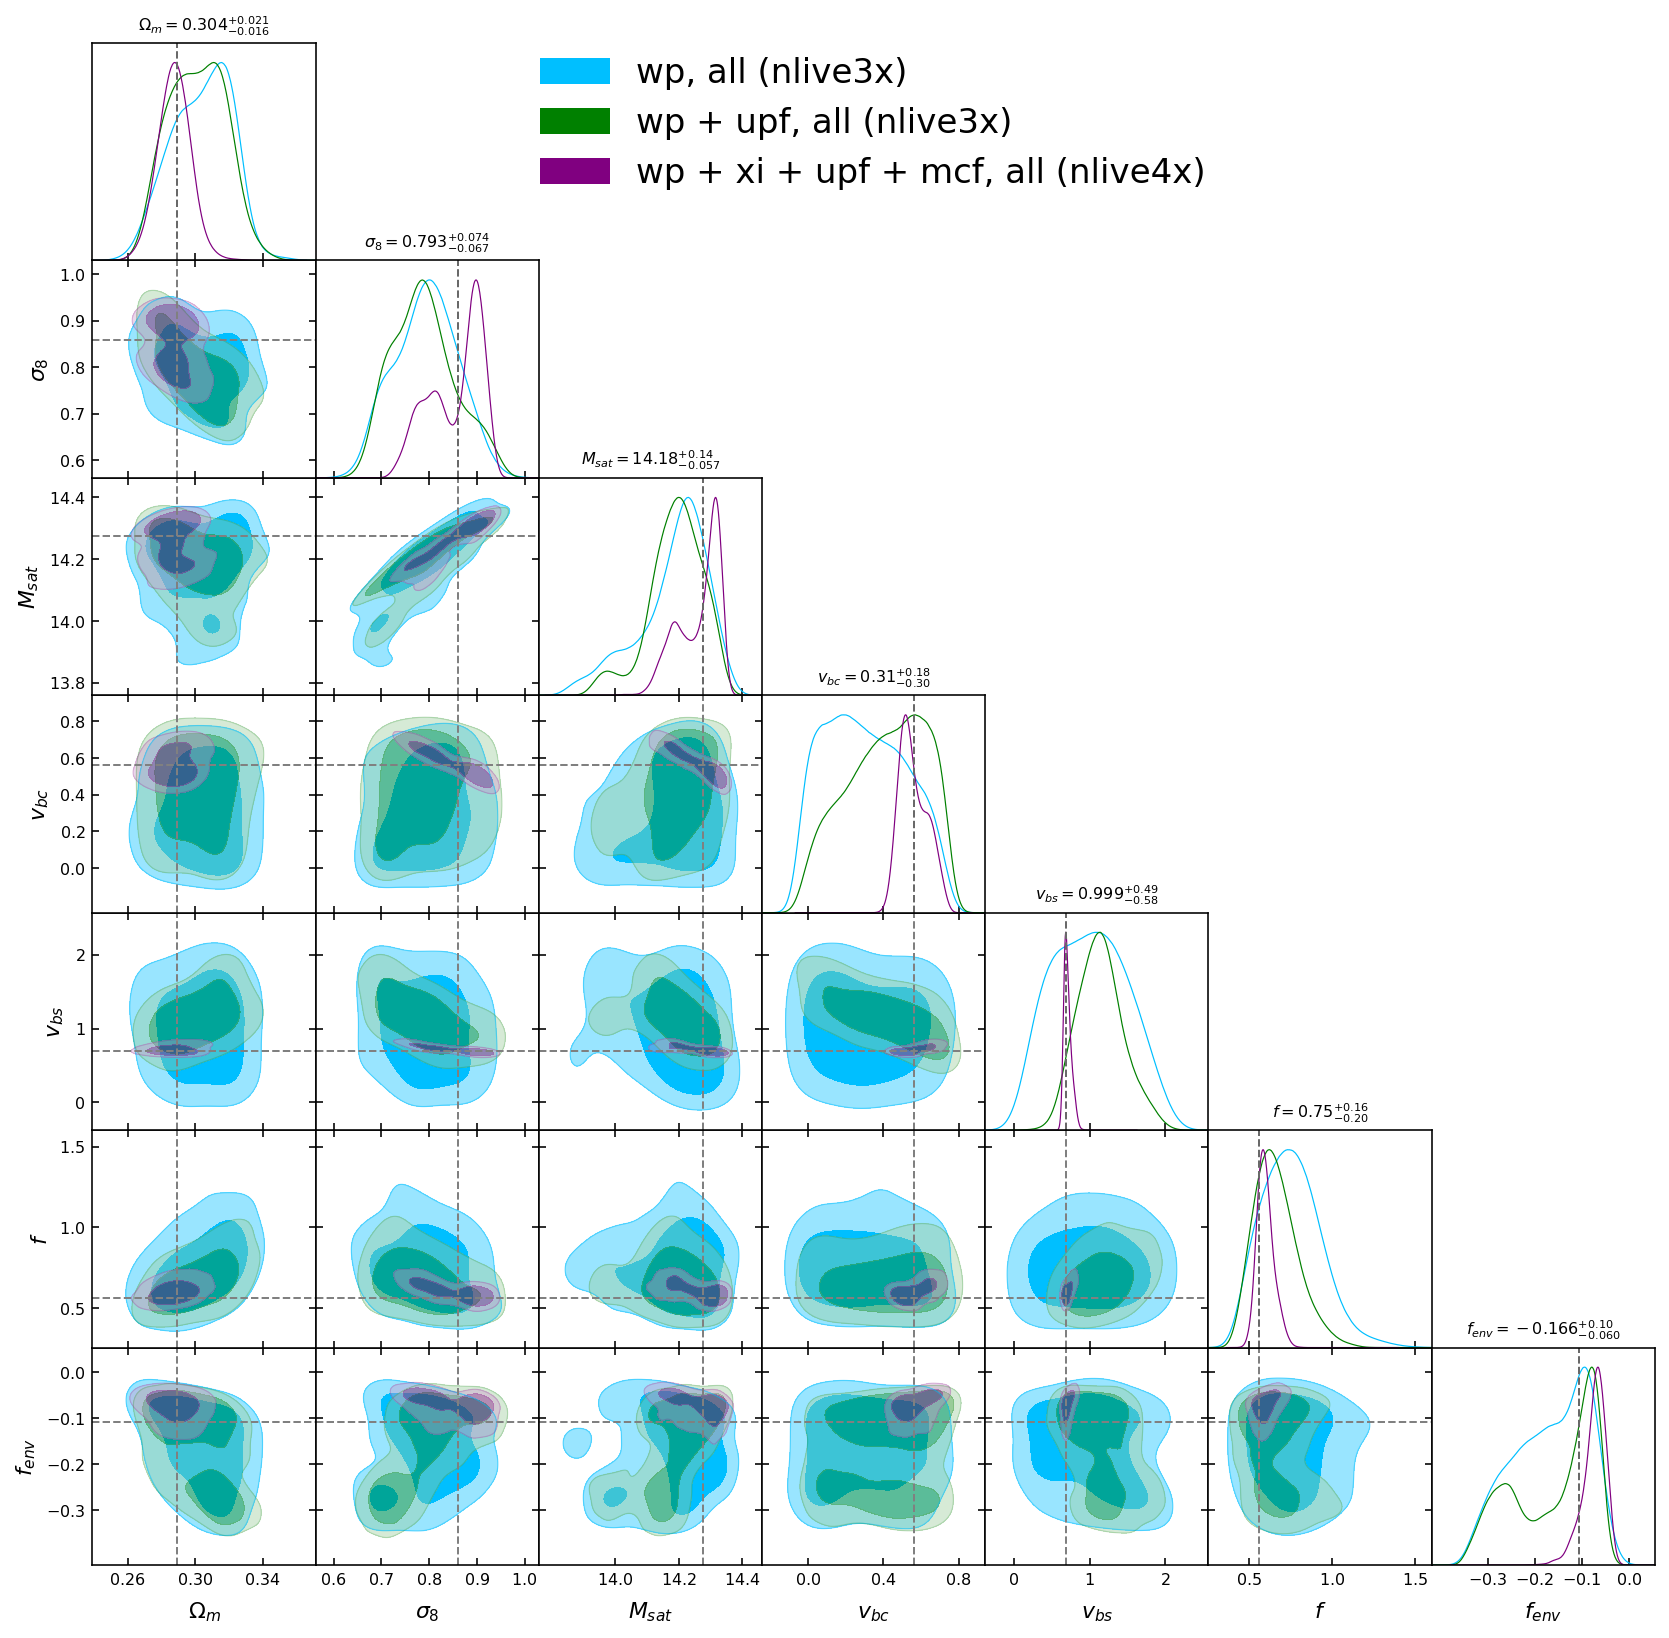

In [13]:
chaintags = ['wp_c3h3_all_dy',
             'wp_upf_c3h3_all_dy',
             'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_fixgperr', #(nlive4x)
            ]
legend_labels = ['wp, all (nlive3x)',
                 'wp + upf, all (nlive3x)',
                 'wp + xi + upf + mcf, all (nlive4x)',
                ]
colors = [cwp, 
          'green',
          'purple',
         ]
plot_contours_dynesty(chaintags, legend_labels=legend_labels,
                      colors=colors, params_toplot=key_params)

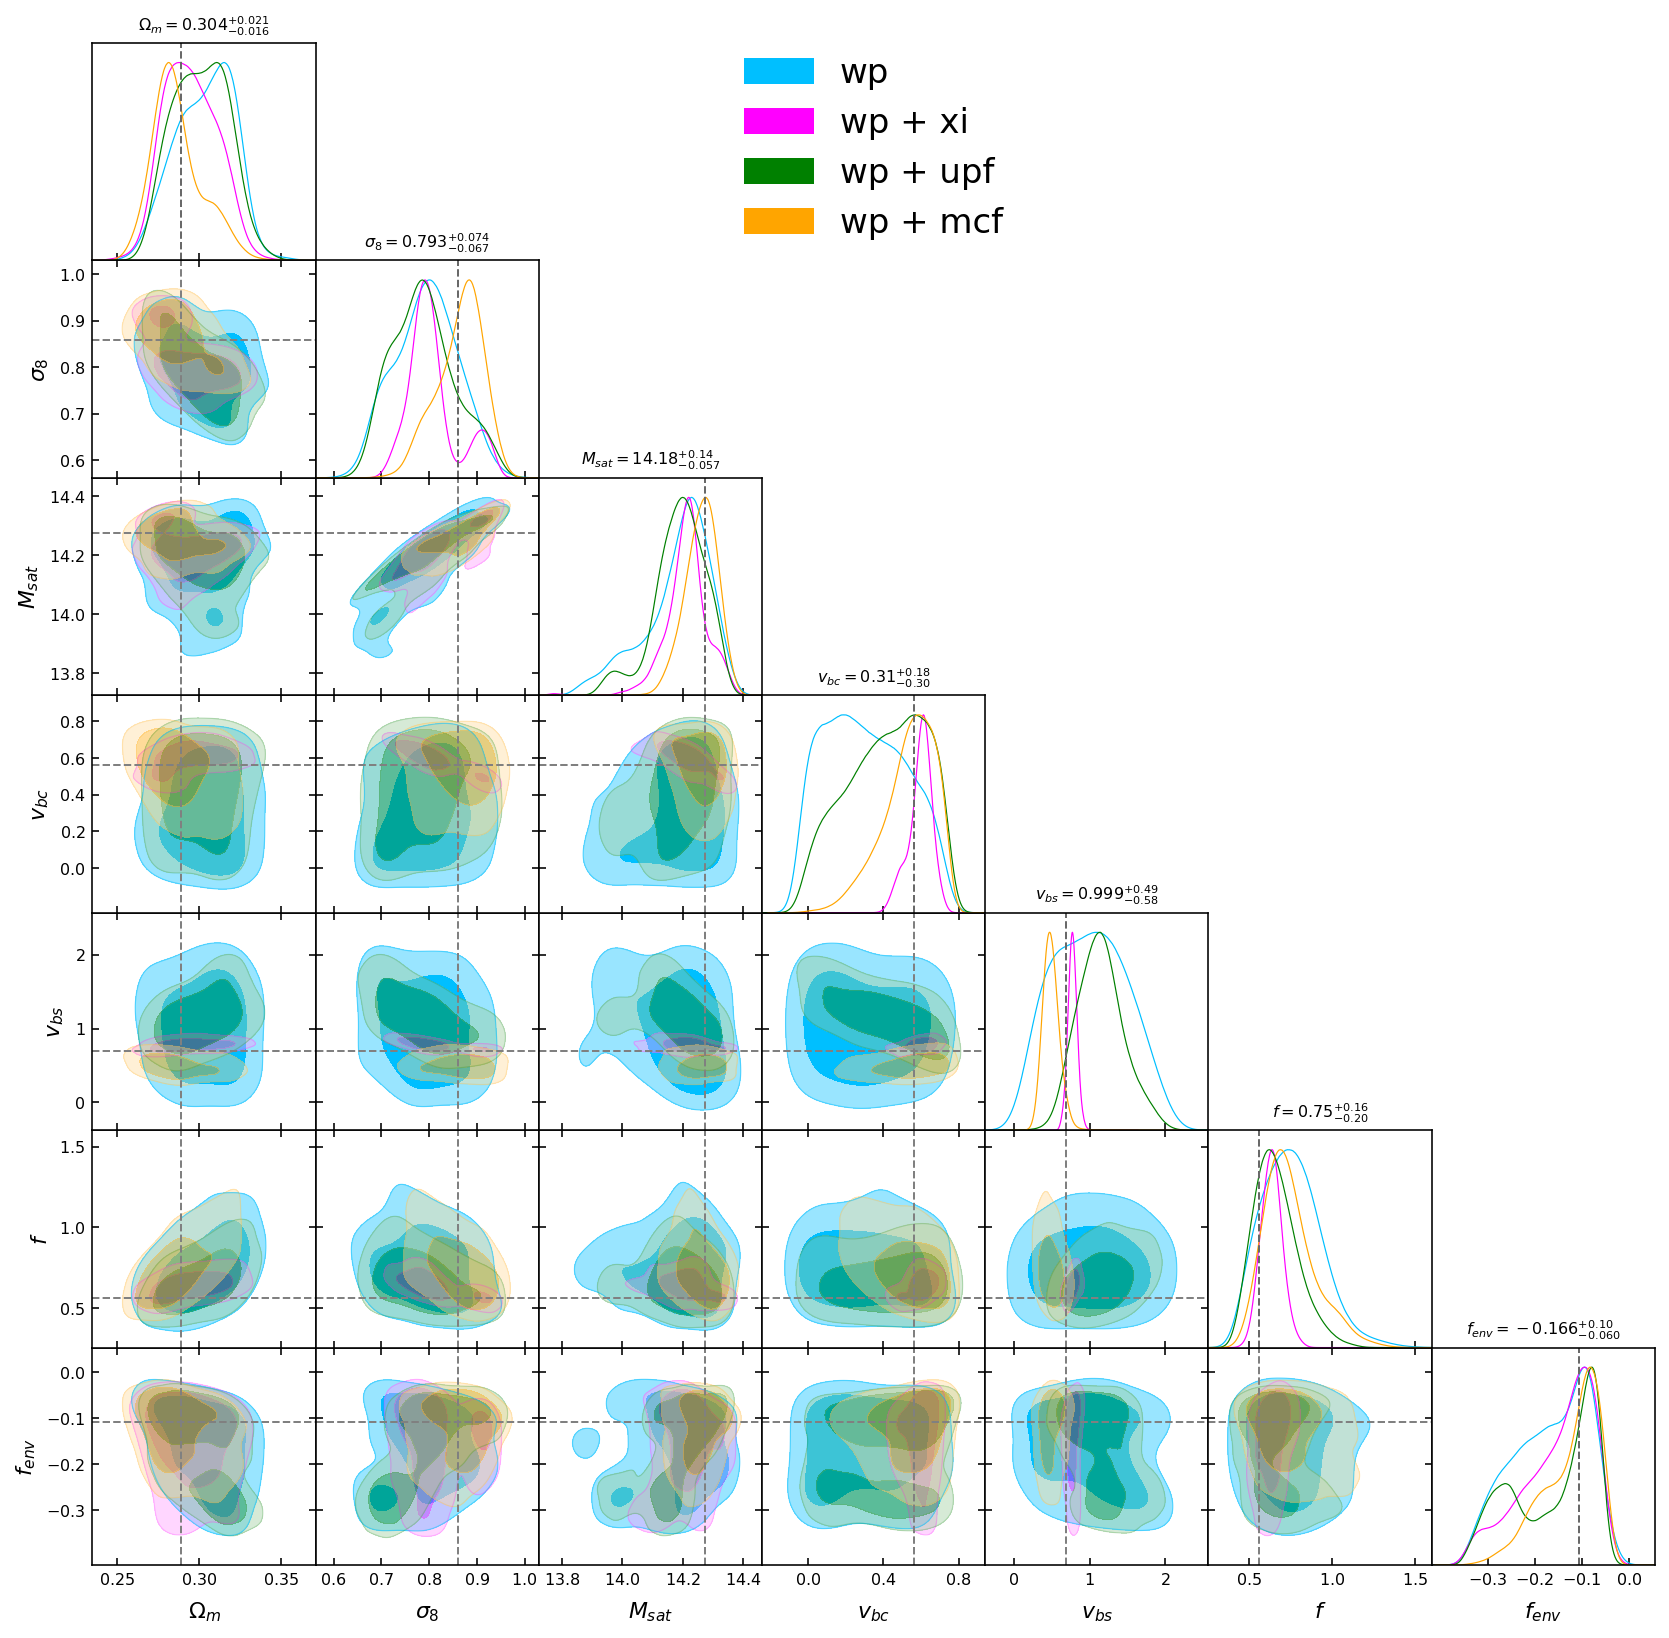

In [9]:
chaintags = ['wp_c3h3_all_dy',
             'wp_xi_c3h3_all_dy',
             'wp_upf_c3h3_all_dy',
             'wp_mcf_c3h3_all_dy',
            ]
legend_labels = ['wp',
                 'wp + xi',
                 'wp + upf',
                 'wp + mcf',
                ]
colors = [cwp, 
          'magenta',
          'green',
          'orange',
         ]
plot_contours_dynesty(chaintags, legend_labels=legend_labels,
                      colors=colors, params_toplot=key_params)

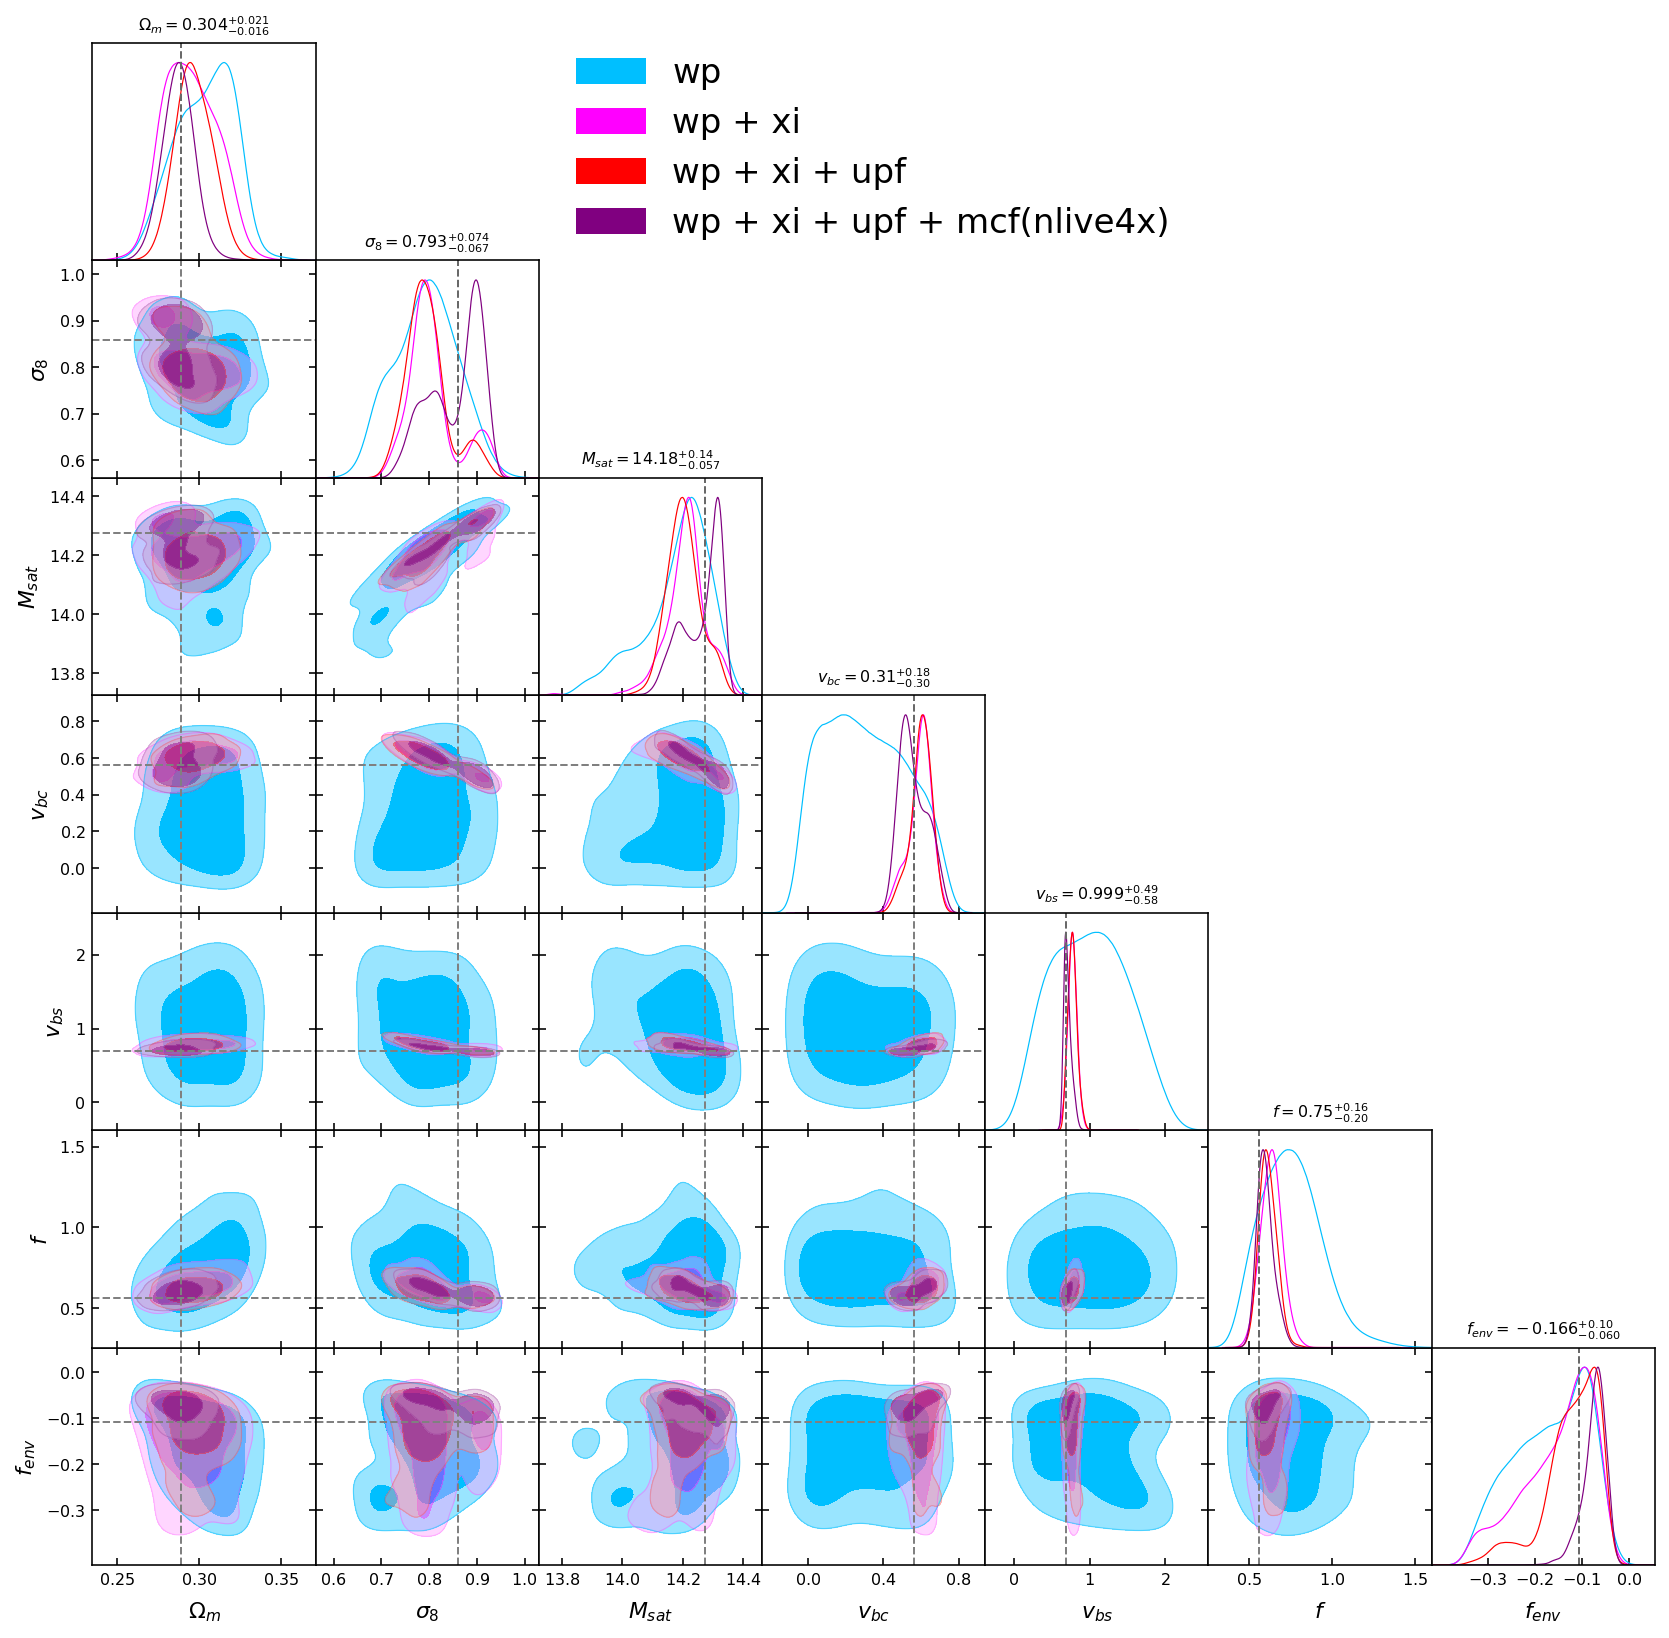

In [11]:
chaintags = ['wp_c3h3_all_dy',
             'wp_xi_c3h3_all_dy',
             'wp_xi_upf_c3h3_all_dy',
             'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_fixgperr', #(nlive4x)
            ]
legend_labels = ['wp',
                 'wp + xi',
                 'wp + xi + upf',
                 'wp + xi + upf + mcf (nlive4x)',
                ]
colors = [cwp, 
          'magenta',
          'red',
          'purple',
         ]
plot_contours_dynesty(chaintags, legend_labels=legend_labels,
                      colors=colors, params_toplot=key_params)